In [ ]:
try:
    import pyro
except:
    ! pip install pyro-ppl
    ! pip install Biopython

     |████████████████████████████████| 718 kB 14.3 MB/s 
     |████████████████████████████████| 2.3 MB 14.0 MB/s 


## Latent Tree

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle
import math

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_train, S_names_train, S_length_train, S_char_train = load_Unaligned_Data("/content/BLAT_ECOLX_1_b0.5.fasta", "cuda", AA_dict)

S_down_train, S_names_down_train, S_length_down_train, S_char_down_train = load_Unaligned_Data("//content/mutation.fas", "cuda", AA_dict)
S_down_train = torch.cat([S_down_train, torch.tensor(23).expand([S_down_train.shape[0], S_train.shape[1] - S_down_train.shape[1]]).to("cuda")], dim=-1)

In [ ]:
Classify_train_p = []
Classify_test_p = []

Classify_train_s = []
Classify_test_s = []


In [ ]:
with open("/content/Labels.pkl", "rb") as f:
    Labels = pickle.load(f)

In [ ]:
batch_size = 50

In [ ]:
Classify_train_p, Classify_test_p, Classify_train_s, Classify_test_s = Classify_train_p[:-5], Classify_test_p[:-5], Classify_train_s[:-5], Classify_test_s[:-5]

100%|██████████| 21/21 [1:21:59<00:00, 234.28s/it]


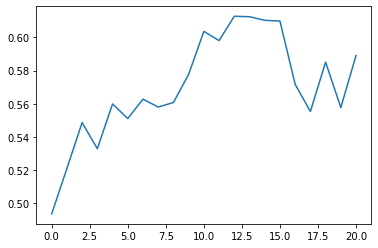

100%|██████████| 21/21 [1:20:50<00:00, 230.98s/it]


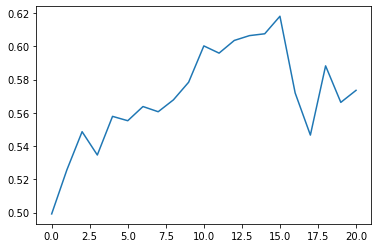

In [ ]:
for _ in range(5):

    for _ in range(5):
        Classify_train_p.append([])
        Classify_test_p.append([])

        Classify_train_s.append([])
        Classify_test_s.append([])
    
    pyro.clear_param_store()
    vae = VAE(100, 24, S_train.shape[1])
    def per_param_callable(module_name, param_name):
        if param_name in ["sigma_f_loc", "sigma_n_loc", "lambd_loc"]:
            return {"lr": 5e-4, "clip_norm": 10}
        else:   
            return {"lr": 0.0005, "clip_norm": 10}
    optimizer = pyro.optim.ClippedAdam(per_param_callable)
    svi = SVI(vae.standard_asr_batched_model_latent_tree, vae.standard_asr_batched_guide_latent_tree, optimizer, loss=Trace_ELBO(num_particles=1))

    for b in tqdm(range(21)):
        indices = np.random.choice(S_train.shape[0], S_train.shape[0], False)

        for batch in range(S_train.shape[0] // batch_size - 1):
          ##if np.random.rand() > 0.1: continue  # otherwise it cannot be finished and colab will cut it down automatically
          batch_idx = indices[batch * batch_size: batch * batch_size + batch_size]
          back_idx = indices[S_train.shape[0] // batch_size * batch_size - batch_size:]
          all_idx = np.concatenate([back_idx, batch_idx])
          elbo = svi.step(aligned_S=S_train[batch_idx],
                  S_length=None,
                  S_index=batch_idx,
                  num_batch=S_train.shape[0] // batch_size - 1,
                  aligned_S_back=S_train[back_idx],
                  S_back_length=None,
                  S_back_index=back_idx,
                  num_instance=S_train.shape[0],
                  tree_emb_dim=100)



        # downstream tast

        S_onehot = torch.zeros_like(S_down_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_down_train[:, :, None], 1)
        MSA = S_onehot[:, :, :].float().cuda()
        
        label_down = np.array([Labels[i] for i in S_names_down_train])

        np.random.seed(42)
        indices = np.random.choice(label_down.shape[0], label_down.shape[0], False)
        np.random.seed(None)

        indices_train = indices[: int(indices.shape[0] * 0.7)]
        indices_test = indices[int(indices.shape[0] * 0.7):]

        label_train = label_down[indices_train]
        label_test = label_down[indices_test]
        
        x_down = vae.encoder(MSA, None).detach().cpu()#torch.cat([vae.encoder(MSA_down, None).detach().cpu(), vae.encoder(MSA_down_wt, None).detach().cpu()], dim=-1)

        x_train = x_down[indices_train]
        x_test = x_down[indices_test]#[test_idx]

        for _i in range(5):

            #classifier = MLPRegressor((100, 300, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
            classifier = MLPRegressor((100, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
            acc_train = pearsonr(label_train, classifier.predict(x_train))[0]
            Classify_train_p[-1-_i].append(acc_train)

            acc_train = spearmanr(label_train, classifier.predict(x_train))[0]
            Classify_train_s[-1-_i].append(acc_train)

            acc_test = pearsonr(label_test, classifier.predict(x_test))[0]
            Classify_test_p[-1-_i].append(acc_test)

            acc_test = spearmanr(label_test, classifier.predict(x_test))[0]
            Classify_test_s[-1-_i].append(acc_test)

    plt.plot(np.array(Classify_test_p).mean(0))
    plt.show()


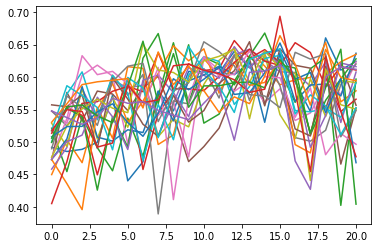

In [ ]:
for i in Classify_test_p:
  plt.plot(i)

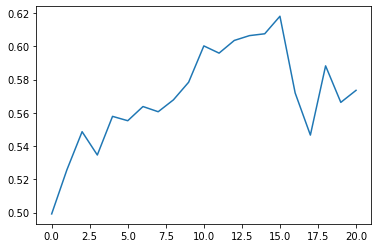

In [ ]:
plt.plot(np.array(Classify_test_p).mean(0))

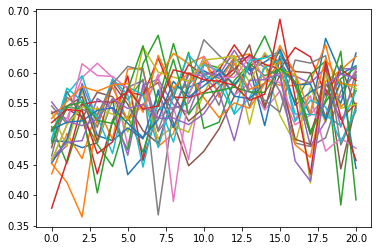

In [ ]:
for i in Classify_test_s:
  plt.plot(i)

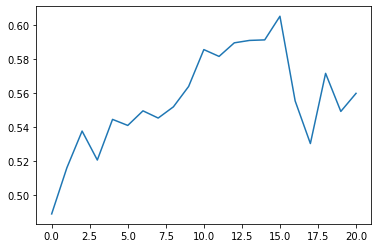

In [ ]:
plt.plot(np.array(Classify_test_s).mean(0))

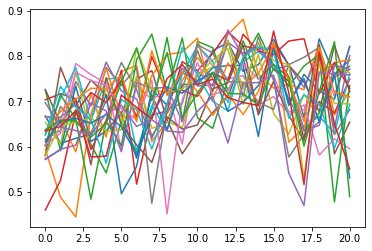

In [ ]:
for i in Classify_train_p:
  plt.plot(i)

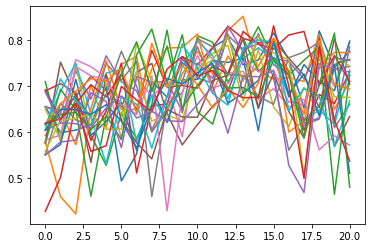

In [ ]:
for i in Classify_train_s:
  plt.plot(i)

In [ ]:
import pickle

with open("track_padding.pkl", "wb") as f:
    pickle.dump((Classify_train_p, Classify_test_p, Classify_train_s, Classify_test_s, [], []), f)

from google.colab import files
files.download("track_padding.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>